# SOAR Project Cookbook

This notebook provides an overview of the approaches I took to solve the Maze-Escape assignment. You don't have to follow the same approach, however, this documentation serves as a guideline on which steps in the data processing pipeline you will need to solve/implement. You can use any examplatory code-blocks provided in this notebook for your own implementation, however, they have to be treated like any other source and cited in your code.

I will provide plots of the data for each step alongside the source code for the visualisation to give you a starting off point for your own documentation.

## Processing Pipeline Concept

<img src="./material/notebookFigures-pipeline.drawio.png" width="600">

_Figure 1: Pipelines for localisation using classification and navigation using search._


## Step 1: Loading and transforming Map and Scan from ROS

Once the simulation of the robot in the maze has been started using `roslaunch soarMazeEscape launchSimulation.launch`, we can start loading the map as well as one of the initial laserscan from ROS. The map is available either as a service or as a ROS message, while the laserscan is available only as a ROS message. Since we will be needing both the map and laserscan only once, I have decided to get the map using a ROS service and delete the laserscan subscriber after having received the first message.

The following two codeblock imports neccesary Python modules and defines a helper function for retrieving the map.


In [1]:
# Import neccesary modules
# Set matplotlib to inline mode for the Jupyter notebook visualisations

%matplotlib inline

import rospy
from sensor_msgs.msg import LaserScan
from nav_msgs.srv import GetMap
from nav_msgs.msg import OccupancyGrid

import numpy as np
import matplotlib.pyplot as plt

import numpy as np

import copy
import time
import math

# Helper method for retrieving the map
def getMap() -> OccupancyGrid:
    """ Loads map from map service """
    # Create service proxy
    get_map = rospy.ServiceProxy('static_map', GetMap)
    # Call service
    recMap = get_map()
    recMap = recMap.map
    # Return
    return recMap

# Initiate ROS node
rospy.init_node('mazeEscape')
recMap = getMap()

In [2]:
# REDACTED CODE BLOCK

However, we now receive the map in form of a [nav_msgs:OccupancyGrid](http://docs.ros.org/en/noetic/api/nav_msgs/html/msg/OccupancyGrid.html). The occupancy grid serialises the map as a one-dimensional array, with metadata such as map height, width and resolution being provided. Therefore, we need to first deserialise the one-dimensional array into the correct, two-dimensional format (see [numpy.split()](https://numpy.org/doc/stable/reference/generated/numpy.split.html)). Based on the provided origin as well as the resolution, we can calculate the positions of all points considered free and all points considered walls by the map. The transformation and corresponding formula are depicted in the next figure.

<img src="./material/notebookFigures-mapTransformation.drawio.png" width="600">

_Figure 2: The map needs to be deserialised and transformed into world coordinates for further processing._

The next step is to transform the laserscan data received in form of a [sensor_msgs:LaserScan](http://docs.ros.org/en/melodic/api/sensor_msgs/html/msg/LaserScan.html) to cartesian coordinates. The message contains the distance (ranges) to detected objects, as well as metadata, such as the starting and end angles of the laserscanner and the angle increment. Have a look at [numpy.arange()](https://numpy.org/doc/stable/reference/generated/numpy.arange.html) for getting the corresponding angles for each distance measurement. The angle-distance pairs need to be converted to cartesian coordinates in order to be in the same space as the map data we transformed earlier. The next figure shows the transformation of the laserscan.

<img src="./material/notebookFigures-scanTransformation.drawio.png" width="600">

_Figure 3: The laserscan data must be transformed from polar to cartesian coordinates for further processing._

**Hint: Due to the walls having thickness, transformed laserscan and walls won't match up perfectly (the laserscan only percieves the edge of the wall). The points can be transformed to perfectly line up, by moving each point away from the laserscan by half the map's resolution.**

The next codeblock shows a visualisation of the transformed map and scan using matplotlib. `freePositions` and `wallPositions` are lists containing the position of each transformed pixel in the map (representing unobstructed space or walls respectively), while `scan` represents walls detected by the laserscan. In this visualisation, the scan will not match up with the map, since we don't know the robot position yet. For a more in-depth explanation of the code seen here, you can have a look at the [Matplotlib Scatterplot Example](https://matplotlib.org/stable/gallery/shapes_and_collections/scatter.html).

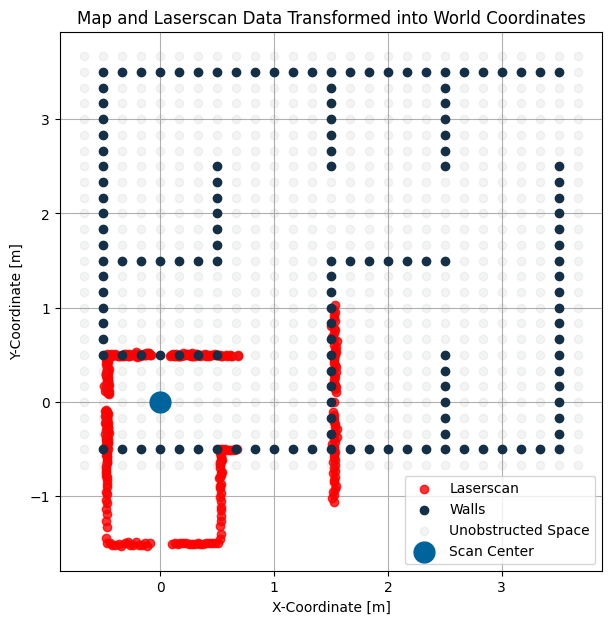

In [3]:
# Store colours matching UAS TW colour scheme as dict 
colourScheme = {
    "darkblue": "#143049",
    "twblue": "#00649C",
    "lightblue": "#8DA3B3",
    "lightgrey": "#CBC0D5",
    "twgrey": "#72777A"
}

## Visualise transformed maze and scans
# Create single figure
plt.rcParams['figure.figsize'] = [7, 7]
fig, ax = plt.subplots()

# Plot data as points (=scatterplot) and label accordingly. The colours are to look nice with UAS TW colours
ax.scatter(scan[:,1], scan[:,0], c="r", alpha=0.8, label="Laserscan")
ax.scatter(wallPositions[:,1], wallPositions[:,0], c=colourScheme["darkblue"], alpha=1.0, s=6**2, label="Walls")
ax.scatter(freePositions[:,1], freePositions[:,0], c=colourScheme["twgrey"], alpha=0.08, s=6**2, label="Unobstructed Space")
ax.scatter([0], [0], c=colourScheme["twblue"], s=15**2, label="Scan Center")

# Set axes labels and figure title
ax.set_xlabel("X-Coordinate [m]")
ax.set_ylabel("Y-Coordinate [m]")
ax.set_title("Map and Laserscan Data Transformed into World Coordinates")

# Set grid to only plot each metre
ax.set_xticks = [-1, 0, 1, 2, 3, 4 ]
ax.set_yticks = [-1, 0, 1, 2, 3, 4 ]

# Move grid behind points
ax.set_axisbelow(True)
ax.grid()

# Add labels
ax.legend()

# Show plot
plt.show()

## Step 2: Localisation using k-Nearest Neighbour

During the theory lecture, we have already discussed the k-Nearest Neghbour (kNN) approach. We will use it alongside assumptions about the environment to localise the robot in the maze. The basic approach will be to fit a kNN model (see lecture 2) to the points representing either unobstructed space or walls. Therefore, the model will interpolate between the discrete points representing our map.

Using the fitted model, we will predict the scan at different positions on the map. For computation to be feasable, we assume that the robot will always be placed at coordinates that are whole numbers (i.e. (0,0), (0,1), (3,4), etc.). Additionally, we will assume that the robot is always facing the x-axis.

You don't have to implement kNN from scratch (if anyone wants to do that voluntarily, you are more than welcome to though). Instead, we will be using the implementation already present in the [scikit-learn](https://scikit-learn.org/stable/) module. The usage of their kNN implementation is shown [here](https://scikit-learn.org/stable/auto_examples/neighbors/plot_classification.html#sphx-glr-auto-examples-neighbors-plot-classification-py).

In order to be fitted, the model requires two lists (X and y). X represents all the points in the dataset used for fitting. In our case, these will be all the coordinates of the map's points in the visualisation above. The second list, y, represents the labels we give each of the points in X. For our use case, these will denote, whether or not a point is unobstructed space or a wall.

In [4]:
# Import kNN implementation
from sklearn import neighbors

In [5]:
# REDACTED CODE BLOCK

KNeighborsClassifier(n_neighbors=1)

The next code cell uses the fitted model (clf) as well as the data used for fitting (X) to visualise the model's boundaries. Using one neighbour for each entry results in our discrete map being turned into a continuous representation of the same map, with boundaries being exactly between each discrete point. Due to the walls being thin in proportion to the corridors, we would need to blur the map in the preprocessing step above to make the localisation work with more than 1 neighbour.

The next image shows, how the maze is represented by the kNN model's boundaries. We use a method built-into scikit-learn for that.

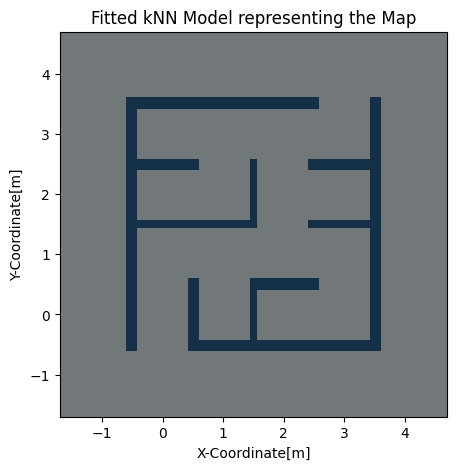

In [6]:
# Imports for visualisation
from matplotlib.colors import ListedColormap
from sklearn.inspection import DecisionBoundaryDisplay

## Visualise fitted model using built-in visualiser
plt.rcParams['figure.figsize'] = [5, 5]
_, ax = plt.subplots()

DecisionBoundaryDisplay.from_estimator(
    clf,
    X,
    cmap=ListedColormap(
        [
            colourScheme["twgrey"],
            colourScheme["darkblue"]
        ]
    ),
    ax=ax,
    response_method="predict",
    plot_method="pcolormesh",
    xlabel="X-Coordinate[m]",
    ylabel="Y-Coordinate[m]",
    shading="auto",
)

# Set title and show plot
ax.set_title("Fitted kNN Model representing the Map")
plt.show()

We will now use the fitted model for localisation. In order to do so, we define all possible poses the robot could be placed at. Next, we iterate over all of these poses and transform the laserscan to be at that pose (see Step 1). Since we assume, that the robot is only placed facing the x-axis, we can drop the rotational transformation and only change the laserscan's position.

We let the model then predict the value of each entry in the transformed scan. From the model, we will receive a list of which of the scan's points it thinks to be matching a wall. By counting how many "wall" predictions we get in return, we can estimate, where the robot is.

The following two code cells visualise the scores from the kNN model as a heatmap. Note that, like in the visualisations above, the robot is at (0,0), therefore, we get the highest score there!

In [7]:
# REDACTED CODE BLOCK

In [8]:
## This cell only serves to make the heatmap colours match the TW colour scheme by defining a custom colourmap.

import re

# Helper function for colours
# See https://matplotlib.org/stable/tutorials/colors/colormaps.html for more information
def createColourmapToWhite(rgb, reverse=False):
    """ Creates a colourmap that fades from rgb colour to white """
    # Unpack tuple and manually create fades with a resolution of 256
    r, g, b = rgb
    N = 256
    vals = np.ones((N, 4))
    # Distinguish between reverse and non-reverse and invert linspace accordingly
    if reverse:
        vals[:, 0] = np.linspace(1, r/N, N)
        vals[:, 1] = np.linspace(1, g/N, N)
        vals[:, 2] = np.linspace(1, b/N, N)
    else:
        vals[:, 0] = np.linspace(r/N, 1, N)
        vals[:, 1] = np.linspace(g/N, 1, N)
        vals[:, 2] = np.linspace(b/N, 1, N)
    return ListedColormap(vals)

def hexstring2rgb(colourstring):
    """ Converts hex colours in string form to rgb values """
    i = re.compile('#')
    colourstring = re.sub(i, '', colourstring)
    return tuple(int(colourstring[i:i+2], 16) for i in (0, 2, 4))

# Create colourmap that fades from white to UAS TW blue for heatmap
heatColourMap = createColourmapToWhite( hexstring2rgb( colourScheme["twblue"] ), reverse=True)

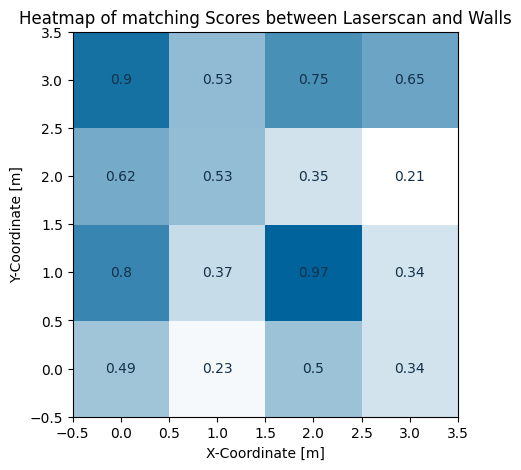

In [9]:
## Visualise scores as heatmap
# Create array holding the scores for imshow
scoreArr = np.zeros((mazeX, mazeY), dtype=np.float64)
for idx, val in zip(pos, scores): scoreArr[idx] = val

# Create figure and plot scores as heatmap
plt.rcParams['figure.figsize'] = [5, 5]
fig, ax = plt.subplots()
im = ax.imshow(scoreArr, cmap=heatColourMap, origin='lower')

# Create Text annotations of each cell
for i in range(mazeX):
    for j in range(mazeY):
        text = ax.text(j, i, "{:.2}".format(scoreArr[i, j]),
                       ha="center", va="center", color=colourScheme["darkblue"])

# Set title and axes descriptions
ax.set_title("Heatmap of matching Scores between Laserscan and Walls")
ax.set_xlabel("X-Coordinate [m]")
ax.set_ylabel("Y-Coordinate [m]")

# Show plot
plt.show()

## Step 3: Exit Maze using Search

During lesson 4, we have already discussed the concept of search algorithms (see Class 4: Introduction to Search Algorithms for the theory behind search). The idea behind search for global path planning is to represent the map as a graph and have the robot find an arbitrary way or the most optimal way between two nodes. 

### Graph Creation

In order to implement search on a graph, we need to think about how we actually represent the nodes and edges that depict the graph. 

Nodes have these properties:
- Position

Edges have these properties:
- Parent Node
- Child Node
- Cost

The graph is created based on data in the map. However, we have to pay attention how a node's position in world-coordinates correlates with the node's position in the array representing the map. You can solve this problem by either impementing functions that convert coordinates to and from map indices using the map's resolution, or you can use X and y from the previous step as a lookup table. The approach is up to you.

In [10]:
# REDACTED CODE BLOCK

The next code cell prints out part of my generated graph for this problem. I used a list of dictionaries to represent the edges, with node positions being encoded in the node's name. Note, that the encoded node positions *x.y* are on the discrete map. Therefore, they need to be converted to world-coordinates, similarly to the approach presented in Step 1.

In [11]:
print(edges[:10])

[{'parent': '4.4', 'child': '10.4'} {'parent': '4.10', 'child': '10.10'}
 {'parent': '4.16', 'child': '4.22'} {'parent': '4.22', 'child': '10.22'}
 {'parent': '10.4', 'child': '10.10'}
 {'parent': '10.10', 'child': '10.16'}
 {'parent': '10.16', 'child': '16.16'}
 {'parent': '10.16', 'child': '10.22'}
 {'parent': '16.4', 'child': '16.10'}
 {'parent': '16.10', 'child': '22.10'}]


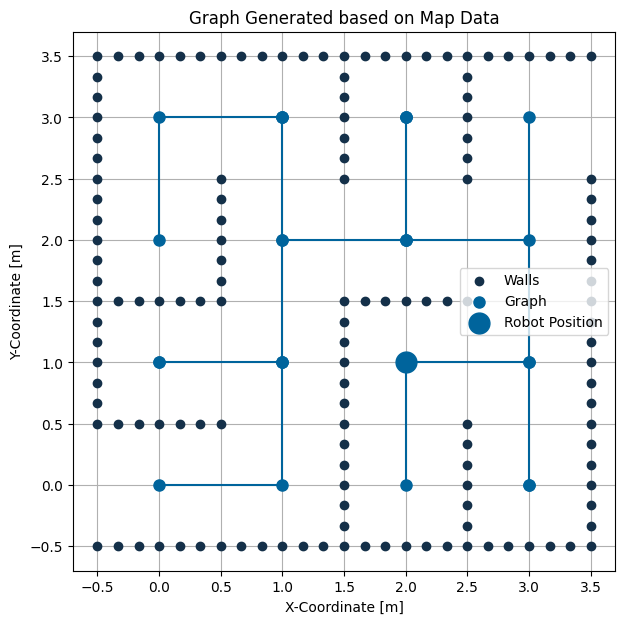

In [12]:
## Visualise maze and generated graph
# Create single figure
plt.rcParams['figure.figsize'] = [7, 7]
fig, ax = plt.subplots()

# Get points on graph
nodePositions = np.array([
    fromNodeName(n["parent"], recMap) for n in edges
] + [
    fromNodeName(n["child"], recMap) for n in edges
])

nodePositions = np.unique(nodePositions, axis=1)

# Get lines connecting the nodes
edgeLines = np.array(
    [
        [
            fromNodeName(n["parent"], recMap),
            fromNodeName(n["child"], recMap)
        ] for n in edges
    ]
)

# Plot data as points (=scatterplot) and label accordingly. The colours are defined to look nice with UAS TW colours
ax.scatter(wallPositions[:,1], wallPositions[:,0], c=colourScheme["darkblue"], alpha=1.0, s=6**2, label="Walls")
ax.scatter(nodePositions[:,1], nodePositions[:,0], c=colourScheme["twblue"], alpha=1.0, s=8**2, label="Graph")
ax.scatter([robotPos[1]], [robotPos[0]], c=colourScheme["twblue"], s=15**2, label="Robot Position")

# Plot lines connecting nodes
for line in edgeLines:
    x0, y0 = line[0]
    x1, y1 = line[1]
    x = [x0, x1]
    y = [y0, y1]
    ax.plot(x, y, c=colourScheme["twblue"])

# Set axes labels and figure title
ax.set_xlabel("X-Coordinate [m]")
ax.set_ylabel("Y-Coordinate [m]")
ax.set_title("Graph Generated based on Map Data")

# Set grid to only plot each metre
ax.set_xticks = [-1, 0, 1, 2, 3, 4 ]
ax.set_yticks = [-1, 0, 1, 2, 3, 4 ]

# Move grid behind points
ax.set_axisbelow(True)
ax.grid()

# Add labels
ax.legend()

# Show plot
plt.show()

### Performing Search

Once the map is properly represented as a graph, it is basically compatible with any search algorithm. The utilised algorithm can be chosen from literature (see Russel & Norvig, 1995: Artificial Intelligence: A Modern Approach, Chapter 2.3 for the algorithms). I will provide pseudocode for Breadth-First Search (BFS) and Depth-First-Search (DFS), since those algorithms are also described in the moodle content.

#### Breadth-First Search

- *discoveredNodes* is a list, that keeps track of nodes the search algorithm has already visited.
- *queue* is a list, that keeps track of which nodes we still have to visit.
- *listParents(discoveredNodes)* lists all parents of all nodes in discoveredNodes.
- *getChildren(graph, node)* lists all children of node on the graph representing the map.
- *pop* means removing the last element of a queue.

```python

discoveredNodes = []

def BFS(currentNode, graph, goal)
    Add currentNode to queue
    while queue not empty:
        n = queue.pop
        if n == goal: return
        for child in getChildren(graph, n):
            if child not in listParents(discoveredNodes):
                add new edge from n to child to discoveredNodes
                add child to queue
```

#### Depth-First Search

- *discoveredNodes* is a list, that keeps track of nodes the search algorithm has already visited.
- *listChildren(discoveredNodes)* lists all children of all nodes in discoveredNodes.
- *getChildren(graph, currentNode)* lists all children of currentNode on the graph representing the map.


```python

discoveredNodes = []

def DFS(currentNode, graph, goal):
    Add currentNode to discoveredNodes
    if goal == currentNode: return
    for child in getChildren(graph, currentNode):
        if child in listChildren(discoveredNodes):
            DFS(node, goal)
```

### Path Reconstruction

Both of these search algorithms return *discoveredNodes*. This is a list containing all nodes the algorithm has traversed during search. In the final step, we need to reconstruct the path from this list of nodes. Due to the nature of the search algorithms, we can assume that (as long as the search was successful), *discoveredNodes* contains our specified start, goal and exactly one path between them. Furthermore, the list presents its own graph, which looks like a tree: starting from any other node on the list, we can traverse from child to parent and will always end up at the startnode. This principle is presented in the next figure.

<img src="./material/notebookFigures-searchTransformation.drawio.png" width="600">

_Figure: This example simulates search on an exemplary graph from node N1 to node N8. The resulting graph after search is shaped like a tree, with all branches leading to the start of the search. Each node is connected to the startnode by one path._

The final step in our implementation is to reconstruct the path by iterating over each node's parent, starting from the goal in *discoveredNodes*. We note each traversed node and calculate its position in world coordinates (i.e. the reverse of the transformation presented in Step 1).

The next block calls the search algorithm based on the graph and determined robot position. Finally, the path is reconstructed from the transformed graph.

In [13]:
# REDACTED CODE BLOCK

Found Path: [array([2., 1.]), array([3., 1.]), array([3., 2.]), array([3., 3.])]


We can now visualise the found robot position, path, maze and laserscan similarly to what RViz will display.

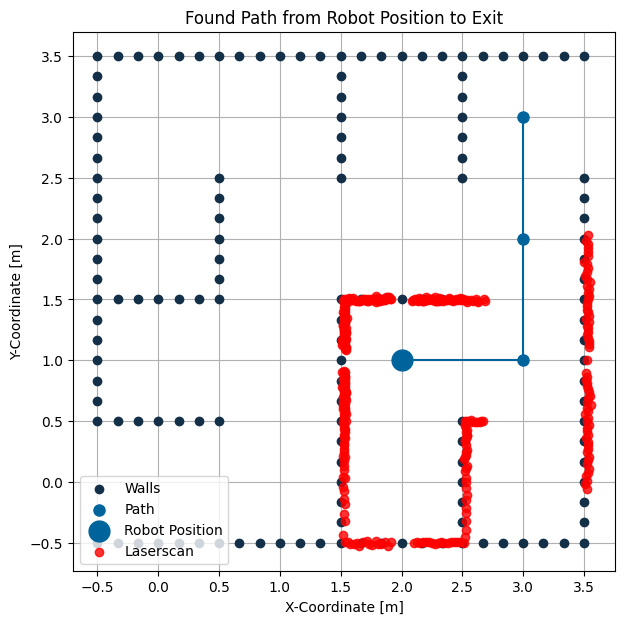

In [14]:
## Visualise maze and found path
# Create single figure
plt.rcParams['figure.figsize'] = [7, 7]
fig, ax = plt.subplots()

## Format found path
# Get points on path
nodePositions = np.array([
    fromNodeName(n, recMap) for n in path
])

# Get lines connecting the nodes
edgeLines = np.array(
    [
        [
            fromNodeName(path[idx-1], recMap),
            fromNodeName(path[idx], recMap)
        ] for idx in range(1, len(path))
    ]
)

## Format scan
# Transform scan from robot to world coordinates
scan = np.array(robotPos)+ scan

# Plot data as points (=scatterplot) and label accordingly. The colours are defined to look nice with UAS TW colours
ax.scatter(wallPositions[:,1], wallPositions[:,0], c=colourScheme["darkblue"], alpha=1.0, s=6**2, label="Walls")
ax.scatter(nodePositions[:,0], nodePositions[:,1], c=colourScheme["twblue"], alpha=1.0, s=8**2, label="Path")
ax.scatter([robotPos[1]], [robotPos[0]], c=colourScheme["twblue"], s=15**2, label="Robot Position")
ax.scatter(scan[:,1], scan[:,0], c="r", alpha=0.8, label="Laserscan")

# Plot lines connecting nodes
for line in edgeLines:
    x0, y0 = line[0]
    x1, y1 = line[1]
    x = [x0, x1]
    y = [y0, y1]
    ax.plot(x, y, c=colourScheme["twblue"])

# Set axes labels and figure title
ax.set_xlabel("X-Coordinate [m]")
ax.set_ylabel("Y-Coordinate [m]")
ax.set_title("Found Path from Robot Position to Exit")

# Set grid to only plot each metre
ax.set_xticks = [-1, 0, 1, 2, 3, 4 ]
ax.set_yticks = [-1, 0, 1, 2, 3, 4 ]

# Move grid behind points
ax.set_axisbelow(True)
ax.grid()

# Add labels
ax.legend()

# Show plot
plt.show()

### Publishing to ROS

For the final step, we convert each node in the found path to a ROS <a href="http://docs.ros.org/en/noetic/api/geometry_msgs/html/msg/PoseStamped.html">geometry_msgs:PoseStamped</a> data type and publish them (in world coordinates) to the ROS move_base, similarly to homework 4 in order to move the robot.

Additionally, the poses can be included in a <a href="http://docs.ros.org/en/noetic/api/nav_msgs/html/msg/Path.html">nav_msgs:Path</a> message for visualisation in RViz.

In [15]:
# REDACTED CODE BLOCK

<img src="./material/notebookMazeEscapeSolvedRViz.png" width="600">

_Figure: In RViz, map, robot, transformations, scan and found path can be visualised similarly to the last matplotlib visualisation._